#  Homework 5 - Berkeley STAT 157

**Your name: Hanmaro Song, 3032216175** (Please add your name, and SID to ease Ryan and Rachel to grade.)

**Please submit your homework through [gradescope](http://gradescope.com/) instead of Github, so you will get the score distribution for each question. Please enroll in the [class](https://www.gradescope.com/courses/42432) by the Entry code: MXG5G5** 

Handout 2/19/2019, due 2/26/2019 by 4pm in Git by committing to your repository.

In this homework, we will model covariate shift and attempt to fix it using logistic regression. This is a fairly realistic scenario for data scientists. To keep things well under control and understandable we will use [Fashion-MNIST](http://d2l.ai/chapter_linear-networks/fashion-mnist.html) as the data to experiment on. 

Follow the instructions from the Fashion MNIST notebook to get the data.

In [1]:
%matplotlib inline
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils
import numpy as np

mnist_train = gdata.vision.FashionMNIST(train=True)
mnist_test = gdata.vision.FashionMNIST(train=False)

In [2]:
import matplotlib.pyplot as plt

## 1. Logistic Regression

1. Implement the logistic loss function $l(y,f) = -\log(1 + \exp(-y f))$ in Gluon.
2. Plot its values and its derivative for $y = 1$ and $f \in [-5, 5]$, using automatic differentiation in Gluon.
3. Generate training and test datasets for a binary classification problem using Fashion-MNIST with class $1$ being a combination of `sneaker` and `pullover` and class $-1$ being the combination of `sandal` and `shirt` categories. 
4. Train a binary classifier of your choice (it can be linear or a simple MLP such as from a previous lecture) using half the data (i.e. $12,000$ observations mixed as abvove) and one using the full dataset (i.e. $24,000$ observations as arising from the 4 categories) and report its accuracy. 

Hint - you should encapsulate the training and reporting code in a callable function since you'll need it quite a bit in the following. 

In [3]:
l = gloss.LogisticLoss()

In [4]:
f = nd.arange(-5, 5, 0.15)
f.attach_grad()

y = nd.ones_like(f)

with autograd.record():
    loss = l(f, y)
    
loss.backward()

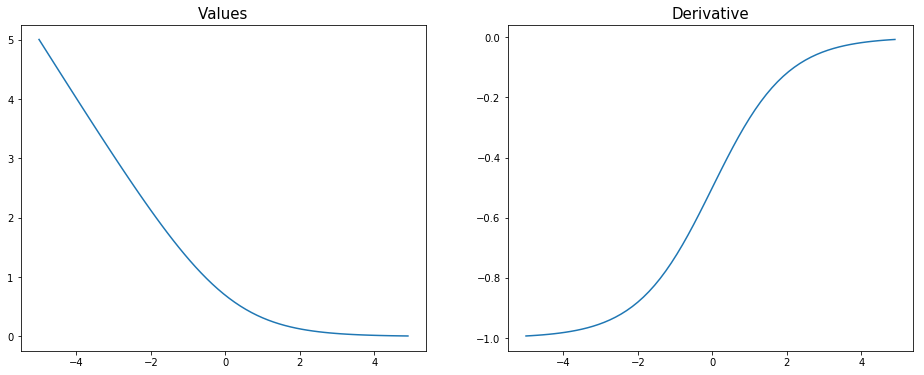

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(f.asnumpy(), loss.asnumpy())
ax[0].set_title('Values', size=15)

ax[1].plot(f.asnumpy(), f.grad.asnumpy())
ax[1].set_title('Derivative', size=15);

In [16]:
def train(net, train_features, train_labels, val_features, val_labels, num_epochs, learning_rate, weight_decay, batch_size):
    
    train_features = train_features.reshape(train_features.shape[0], -1)
    val_features = val_features.reshape(val_features.shape[0], -1)
    
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    
    
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})

    acc = []
    training_accuracy = 0
    
    for epoch in range(num_epochs):

        for X, y in train_iter:

            with autograd.record():
                out = net(X)
                loss = l(out, y)
                
            loss.backward()
            training_accuracy = eval_accuracy(out, y)
            trainer.step(batch_size)
            
        
        if epoch % 2 == 0:
            
            output = net(X)
            
            accuracy = eval_accuracy(output, y)
            acc.append(accuracy)
            print(f"Epoch : {epoch} / {num_epochs}, Training Accuracy: {accuracy}")

    pred = net(val_features)
    validation_accuracy = eval_accuracy(pred, val_labels)
    
    print(f'Validation Accuracy : , {validation_accuracy}')
    
    return net, training_accuracy, validation_accuracy


def eval_accuracy(pred, y):
    
    pred = pred.reshape(1, -1)
    pred = nd.sign(pred)
    num_correct = nd.sum(pred == y)
    
    return round(num_correct.asscalar() / (len(y) + 1e-08), 3)


def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid


def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
    return net, train_l_sum / k, valid_l_sum / k


def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return np.array([text_labels[int(i)] for i in labels])


# Split Training Dataset by given size 
def split_dataset(size, lambd = None):
    
    if lambd is None:
        size1 = size2 = size
    else:
        size1 = int(size * lambd)
        size2 = abs(size - size1)
    
    X_pos = np.vstack((train_shirt[:size1], train_pullover[:size2]))
    y_pos = np.ones(X_pos.shape[0])

    X_neg = np.vstack((train_sandal[:size1], train_sneaker[:size2]))
    y_neg = -np.ones(X_neg.shape[0])

    X_train = np.vstack((X_pos, X_neg))
    y_train = np.concatenate((y_pos, y_neg))
        
    
    return nd.array(X_train), nd.array(y_train)

In [7]:
train_data = mnist_train._data.asnumpy()
train_label = mnist_train._label
train_text = get_fashion_mnist_labels(train_label)

test_data = mnist_test._data.asnumpy()
test_label = mnist_test._label
test_text = get_fashion_mnist_labels(test_label)

In [15]:
# For Training
train_pullover = train_data[train_text == 'pullover']
train_shirt = train_data[train_text == 'shirt']

train_sandal = train_data[train_text == 'sandal']
train_sneaker = train_data[train_text == 'sneaker']


# For Validation
test_pullover = test_data[test_text == 'pullover']
test_shirt = test_data[test_text == 'shirt']

test_sandal = test_data[test_text == 'sandal']
test_sneaker = test_data[test_text == 'sneaker']


X_val = nd.array(np.vstack((test_pullover, test_shirt, test_sneaker, test_sandal)))
y_val = nd.array(np.concatenate((np.ones(test_pullover.shape[0]*2), -np.ones(test_pullover.shape[0]*2))))

In [22]:
X_train_half, y_train_half = split_dataset(3000)
X_train_full, y_train_full = split_dataset(6000)

In [10]:
def get_net():
    
    net = nn.Sequential()
    net.add(nn.Dense(800, activation='relu'))
    net.add(nn.Dropout(.5))
    net.add(nn.BatchNorm())
    net.add(nn.Dense(400, activation='relu'))
    net.add(nn.Dropout(.5))
    net.add(nn.BatchNorm())
    net.add(nn.Dense(200, activation='relu'))
    net.add(nn.Dropout(.5))
    net.add(nn.BatchNorm())
    net.add(nn.Dense(1))
    net.collect_params().initialize(init.Xavier(magnitude=2.24))

    return net

### Using Half Dataset

Setting num_epochs to a larger value can achieve almost perfect accuracy for both training and validation sets so I only set it as 10 to see the different easily. But still it achieves high accuracy.

In [28]:
num_epochs = 10
learning_rate = 1e-04
batch_size = 1000
weight_decay = 0.9

In [21]:
net, _, _ = train(get_net(), X_train_half, y_train_half, X_val, y_val, num_epochs=num_epochs, learning_rate=learning_rate, 
                      weight_decay=weight_decay, batch_size=batch_size)

Epoch : 0 / 50, Training Accuracy: 0.632
Epoch : 2 / 50, Training Accuracy: 0.762
Epoch : 4 / 50, Training Accuracy: 0.876
Epoch : 6 / 50, Training Accuracy: 0.952
Epoch : 8 / 50, Training Accuracy: 0.981
Epoch : 10 / 50, Training Accuracy: 0.986
Epoch : 12 / 50, Training Accuracy: 0.986
Epoch : 14 / 50, Training Accuracy: 0.997
Epoch : 16 / 50, Training Accuracy: 0.996
Epoch : 18 / 50, Training Accuracy: 0.995
Epoch : 20 / 50, Training Accuracy: 0.997
Epoch : 22 / 50, Training Accuracy: 0.997
Epoch : 24 / 50, Training Accuracy: 0.997
Epoch : 26 / 50, Training Accuracy: 1.0
Epoch : 28 / 50, Training Accuracy: 0.998
Epoch : 30 / 50, Training Accuracy: 0.997
Epoch : 32 / 50, Training Accuracy: 0.997
Epoch : 34 / 50, Training Accuracy: 0.998
Epoch : 36 / 50, Training Accuracy: 0.999
Epoch : 38 / 50, Training Accuracy: 0.996
Epoch : 40 / 50, Training Accuracy: 0.999
Epoch : 42 / 50, Training Accuracy: 0.999
Epoch : 44 / 50, Training Accuracy: 0.999
Epoch : 46 / 50, Training Accuracy: 0.998

### Using Full Dataset

In [13]:
net, _, _ = train(get_net(), X_train_full, y_train_full, X_val, y_val, num_epochs=num_epochs, learning_rate=learning_rate, 
                      weight_decay=weight_decay, batch_size=batch_size)

Epoch : 0 / 50, Training Accuracy: 0.534
Epoch : 2 / 50, Training Accuracy: 0.708
Epoch : 4 / 50, Training Accuracy: 0.796
Epoch : 6 / 50, Training Accuracy: 0.799
Epoch : 8 / 50, Training Accuracy: 0.827
Epoch : 10 / 50, Training Accuracy: 0.832
Epoch : 12 / 50, Training Accuracy: 0.855
Epoch : 14 / 50, Training Accuracy: 0.884
Epoch : 16 / 50, Training Accuracy: 0.883
Epoch : 18 / 50, Training Accuracy: 0.904
Epoch : 20 / 50, Training Accuracy: 0.914
Epoch : 22 / 50, Training Accuracy: 0.914
Epoch : 24 / 50, Training Accuracy: 0.91
Epoch : 26 / 50, Training Accuracy: 0.908
Epoch : 28 / 50, Training Accuracy: 0.924
Epoch : 30 / 50, Training Accuracy: 0.925
Epoch : 32 / 50, Training Accuracy: 0.933
Epoch : 34 / 50, Training Accuracy: 0.931
Epoch : 36 / 50, Training Accuracy: 0.87
Epoch : 38 / 50, Training Accuracy: 0.928
Epoch : 40 / 50, Training Accuracy: 0.902
Epoch : 42 / 50, Training Accuracy: 0.917
Epoch : 44 / 50, Training Accuracy: 0.932
Epoch : 46 / 50, Training Accuracy: 0.922

## 2. Covariate Shift

Your goal is to introduce covariate shit in the data and observe the accuracy. For this, compose a dataset of $12,000$ observations, given by a mixture of `sneaker` and `pullover` and of `sandal` and `shirt` respectively, where you use a fraction $\lambda \in \{0.05, 0.1, 0.2, \ldots 0.8, 0.9, 0.95\}$ of one and a fraction of $1-\lambda$ of  the other datasets respectively. For instance, you might pick for $\lambda = 0.1$ a total of $600$ `sneaker` and $5,400$ `pullover` images and likewise $600$ `sandal` and $5,400$ `shirt` photos, yielding a total of $12,000$ images for training. Note that the test set remains unbiased, composed of $2,000$ photos for the `sneaker` + `pullover` category and of the `sandal` + `shirt` category each.

1. Generate training sets that are appropriately biased. You should have 11 datasets.
2. Train a binary classifier using this and report the test set accuracy on the unbiased test set. 

In [29]:
lambd = [.05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95]
training_accuracy = []
test_accuracy = []

for lam in lambd:
    X_train, y_train = split_dataset(6000, lam)
    
    print(f'lambda value : {lam}')
    net, tr_acc, te_acc = train(get_net(), X_train, y_train, X_val, y_val, num_epochs=num_epochs, learning_rate=learning_rate, 
                      weight_decay=weight_decay, batch_size=batch_size)
    
    training_accuracy.append(tr_acc)
    test_accuracy.append(te_acc)

lambda value : 0.05
Epoch : 0 / 10, Training Accuracy: 0.74
Epoch : 2 / 10, Training Accuracy: 0.916
Epoch : 4 / 10, Training Accuracy: 0.947
Epoch : 6 / 10, Training Accuracy: 0.982
Epoch : 8 / 10, Training Accuracy: 0.98
Validation Accuracy : , 0.945
lambda value : 0.1
Epoch : 0 / 10, Training Accuracy: 0.833
Epoch : 2 / 10, Training Accuracy: 0.877
Epoch : 4 / 10, Training Accuracy: 0.928
Epoch : 6 / 10, Training Accuracy: 0.961
Epoch : 8 / 10, Training Accuracy: 0.97
Validation Accuracy : , 0.928
lambda value : 0.2
Epoch : 0 / 10, Training Accuracy: 0.862
Epoch : 2 / 10, Training Accuracy: 0.973
Epoch : 4 / 10, Training Accuracy: 0.983
Epoch : 6 / 10, Training Accuracy: 0.989
Epoch : 8 / 10, Training Accuracy: 0.991
Validation Accuracy : , 0.986
lambda value : 0.3
Epoch : 0 / 10, Training Accuracy: 0.779
Epoch : 2 / 10, Training Accuracy: 0.934
Epoch : 4 / 10, Training Accuracy: 0.976
Epoch : 6 / 10, Training Accuracy: 0.972
Epoch : 8 / 10, Training Accuracy: 0.985
Validation Accur

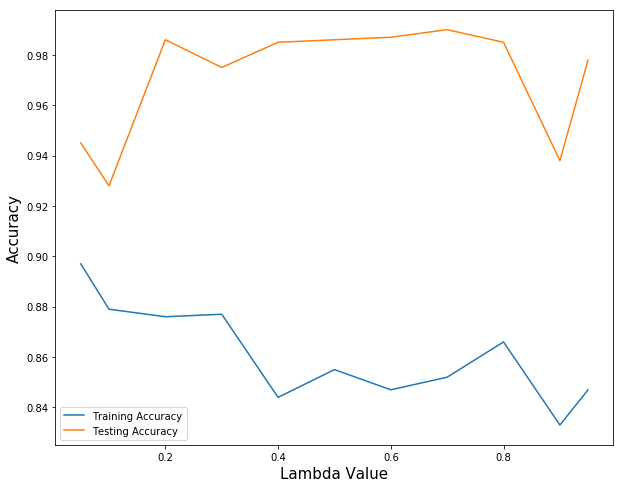

In [30]:
plt.figure(figsize=(10,8))

plt.plot(lambd, training_accuracy, label='Training Accuracy')
plt.plot(lambd, test_accuracy, label='Testing Accuracy')
plt.xlabel('Lambda Value', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend();

## 3. Covariate Shift Correction

Having observed that covariate shift can be harmful, let's try fixing it. For this we first need to compute the appropriate propensity scores $\frac{dp(x)}{dq(x)}$. For this purpose pick a biased dataset, let's say with $\lambda = 0.1$ and try to fix the covariate shift.

1. When training a logistic regression binary classifier to fix covariate shift, we assumed so far that both sets are of equal size. Show that re-weighting data in training and test set appropriately can help address the issue when both datasets have different size. What is the weighting?
2. Train a binary classifier (using logistic regression) distinguishing between the biased training set and the unbiased test set. Note - you need to weigh the data. 
3. Use the scores to compute weights on the training set. Do they match the weight arising from the biasing distribution $\lambda$? 
4. Train a binary classifier of the covariate shifted problem using the weights obtained previously and report the accuracy. Note - you will need to modify the training loop slightly such that you can compute the gradient of a weighted sum of losses. 


In [31]:
lamb = 0.1

X_train, y_train = split_dataset(6000, lamb)

net, tr_acc, te_acc = train(get_net(), X_train, y_train, X_val, y_val, num_epochs=num_epochs, learning_rate=learning_rate, 
                      weight_decay=weight_decay, batch_size=batch_size)


Epoch : 0 / 10, Training Accuracy: 0.799
Epoch : 2 / 10, Training Accuracy: 0.939
Epoch : 4 / 10, Training Accuracy: 0.979
Epoch : 6 / 10, Training Accuracy: 0.982
Epoch : 8 / 10, Training Accuracy: 0.984
Validation Accuracy : , 0.971


In [70]:
l = gloss.SigmoidBinaryCrossEntropyLoss()

np = sum(y_train == 1)
nq = sum(y_val == 1)

pred = net(X_train)
alpha = np/nq * nd.exp(pred)



Accuracy before scaling

In [71]:
eval_accuracy(pred, y_train)

0.991

In [72]:
pred = l(pred, y_train) * alpha.reshape(-1)

Accuracy After

In [73]:
eval_accuracy(pred, y_train)

0.986